=== Pulse 't1c' ===


/tmp/ipykernel_25036/4146479714.py:42: RuntimeWarning: divide by zero encountered in log10
  return 10.0 * np.log10((peak ** 2) / mse)
/home/mario/miniconda3/envs/meningioma/lib/python3.10/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/mario/miniconda3/envs/meningioma/lib/python3.10/site-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start
/home/mario/miniconda3/envs/meningioma/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/mario/miniconda3/envs/meningioma/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


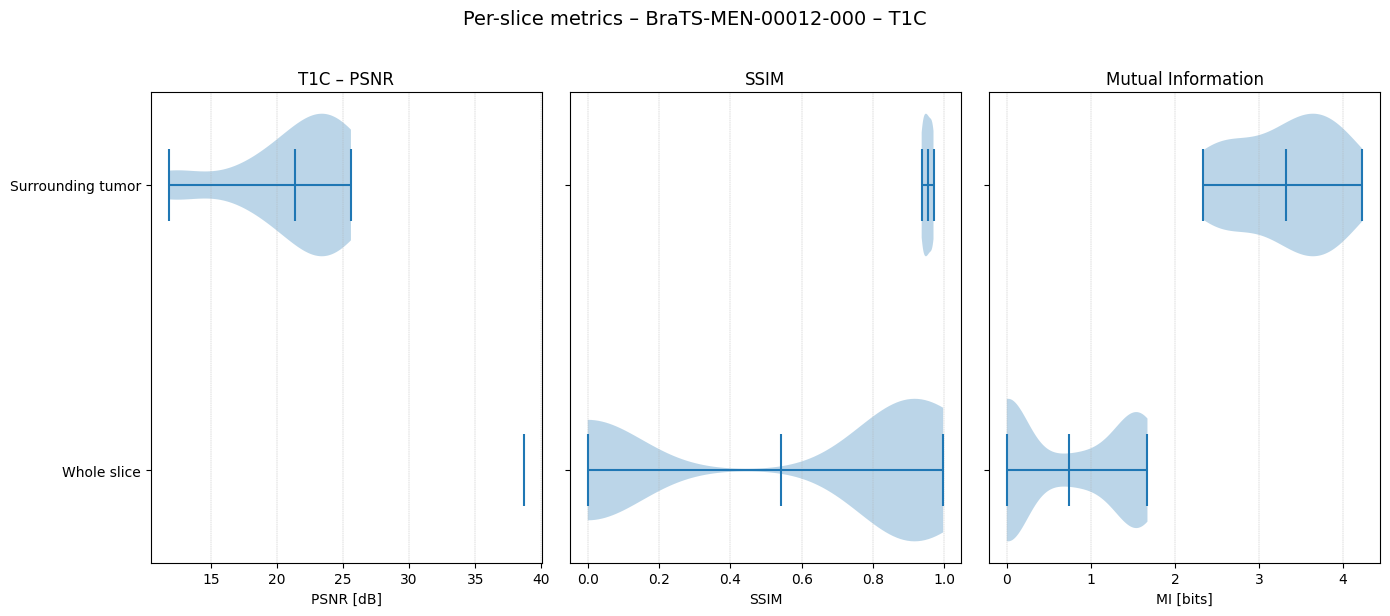

=== Pulse 't2w' ===


/tmp/ipykernel_25036/4146479714.py:42: RuntimeWarning: divide by zero encountered in log10
  return 10.0 * np.log10((peak ** 2) / mse)
/home/mario/miniconda3/envs/meningioma/lib/python3.10/site-packages/skimage/metrics/_structural_similarity.py:269: RuntimeWarning: invalid value encountered in divide
  S = (A1 * A2) / D
/home/mario/miniconda3/envs/meningioma/lib/python3.10/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/mario/miniconda3/envs/meningioma/lib/python3.10/site-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start
/home/mario/miniconda3/envs/meningioma/lib/python3.10/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/mario/miniconda3/envs/meningioma/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, 

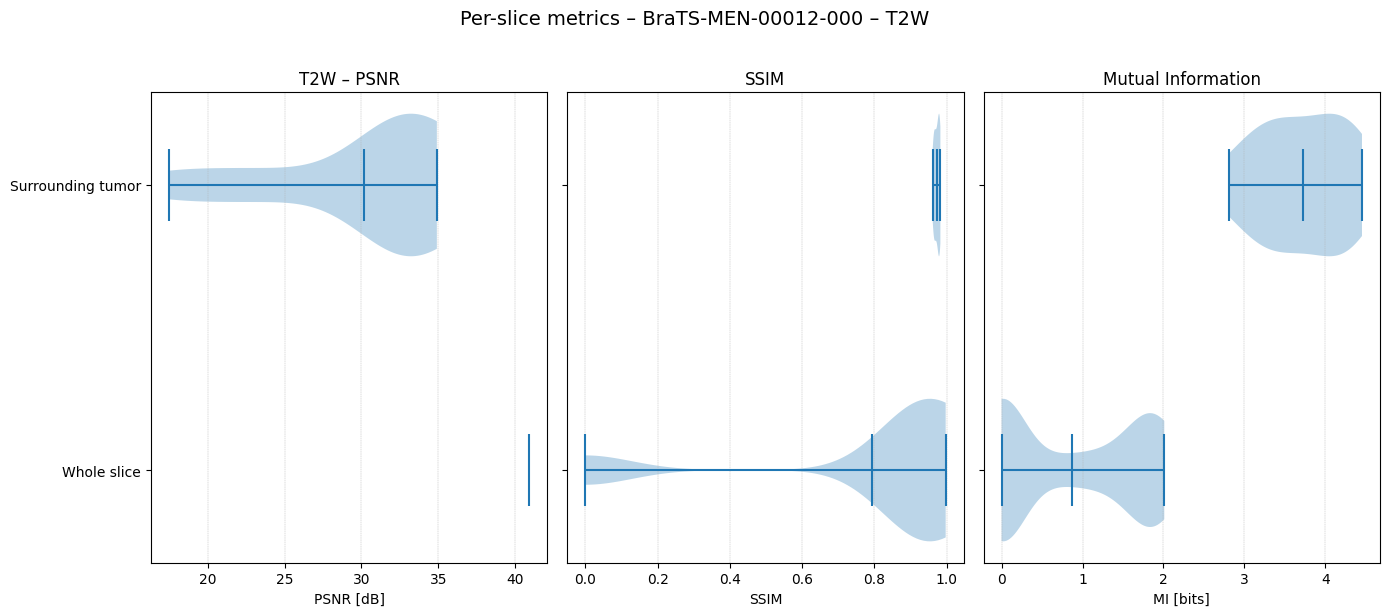


Highest-performing slice per metric & region:


,Pulse,Region,Metric,Slice,Value
5,T1C,Surrounding tumor,MI,67,4.226567
2,T1C,Whole slice,MI,105,1.672198
3,T1C,Surrounding tumor,PSNR,58,25.595698
0,T1C,Whole slice,PSNR,189,38.697842
4,T1C,Surrounding tumor,SSIM,55,0.969404
1,T1C,Whole slice,SSIM,189,0.996496
11,T2W,Surrounding tumor,MI,67,4.452966
8,T2W,Whole slice,MI,118,2.010101
9,T2W,Surrounding tumor,PSNR,58,34.897512
6,T2W,Whole slice,PSNR,189,40.908483



Lowest-performing slice per metric & region:


,Pulse,Region,Metric,Slice,Value
5,T1C,Surrounding tumor,MI,57,2.336133e+00
2,T1C,Whole slice,MI,32,-2.371095e-16
3,T1C,Surrounding tumor,PSNR,53,1.180984e+01
0,T1C,Whole slice,PSNR,0,-inf
4,T1C,Surrounding tumor,SSIM,67,9.362008e-01
1,T1C,Whole slice,SSIM,0,0.000000e+00
11,T2W,Surrounding tumor,MI,59,2.805474e+00
8,T2W,Whole slice,MI,47,-4.201010e-16
9,T2W,Surrounding tumor,PSNR,53,1.749449e+01
6,T2W,Whole slice,PSNR,0,-inf


In [15]:
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from skimage.metrics import structural_similarity as ssim

# ------------------------------------------------------------------
# --------------------------- PARAMETERS ---------------------------
HR      = Path("/home/mario/x2go_shared/sr/original_volumes/BraTS-MEN-00012-000")
SR      = Path("/home/mario/x2go_shared/sr/output_volumes")
PULSES  = ["t1c", "t2w"]

label_names = {1: "Enhancing core", 2: "Edema", 3: "Surrounding tumor"}
slice_axis  = 0        # 0 → axial (first dimension after RAS+ canonicalisation)
max_val     = None     # None → slice-wise dynamic range
mi_bins     = 64       # histogram bins for MI
# ------------------------------------------------------------------

# ---------- metric helpers ---------------------------------------------------
def compute_psnr_slice(hr: np.ndarray,
                       sr: np.ndarray,
                       mask: Optional[np.ndarray] = None,
                       max_val: Optional[float] = None) -> float:
    """
    Peak-Signal-to-Noise Ratio [dB] on a single slice or ROI.
    Returns np.nan if the ROI is empty, np.inf if hr == sr pixel-wise.
    """
    if mask is not None:
        idx = mask.astype(bool)
        if not np.any(idx):
            return np.nan
        diff = hr[idx] - sr[idx]
    else:
        diff = hr - sr

    mse = np.mean(diff ** 2, dtype=np.float64)
    if mse == 0:
        return np.inf
    peak = max_val if max_val is not None else float(np.max(hr))
    return 10.0 * np.log10((peak ** 2) / mse)


def compute_ssim_slice(hr: np.ndarray,
                       sr: np.ndarray,
                       mask: Optional[np.ndarray] = None,
                       win_size: int = 7) -> float:
    """
    Structural Similarity (windowed, default 7×7) on a slice or ROI.
    Returns np.nan if the ROI is empty or smaller than win_size².
    """
    if mask is not None:
        idx = mask.astype(bool)
        if np.count_nonzero(idx) < win_size ** 2:
            return np.nan
        return ssim(hr, sr, win_size=win_size,
                    data_range=hr.max() - hr.min(), mask=idx)
    return ssim(hr, sr, win_size=win_size,
                data_range=hr.max() - hr.min())


def compute_mi_slice(hr: np.ndarray,
                     sr: np.ndarray,
                     mask: Optional[np.ndarray] = None,
                     bins: int = 64) -> float:
    """
    Mutual Information [bits] between two slices or ROIs.

    Parameters
    ----------
    hr, sr : 2-D np.ndarray
    mask   : binary ROI of same shape, or None for whole slice
    bins   : joint-histogram bin count

    Returns
    -------
    float
        MI in bits (0 bits if both images are constant), np.nan if ROI empty.
    """
    # --- prepare vectors -----------------------------------------------------
    if mask is not None:
        idx = mask.astype(bool)
        if not np.any(idx):
            return np.nan
        x = hr[idx].ravel()
        y = sr[idx].ravel()
    else:
        x = hr.ravel()
        y = sr.ravel()

    # Short-circuit if both vectors are constant -----------------------------
    if np.all(x == x.flat[0]) and np.all(y == y.flat[0]):
        return 0.0        # zero mutual information

    # --- joint histogram -----------------------------------------------------
    h2d, *_ = np.histogram2d(x, y, bins=bins)
    p_xy = h2d / h2d.sum()

    p_x = p_xy.sum(axis=1, keepdims=True)   # (bins, 1)
    p_y = p_xy.sum(axis=0, keepdims=True)   # (1, bins)

    denom = p_x * p_y                       # (bins, bins)
    nz = p_xy > 0                           # mask of valid cells

    mi_nats = np.sum(p_xy[nz] * np.log(p_xy[nz] / denom[nz]))
    return mi_nats / np.log(2.0)            # convert nats → bits

# ------------------------------------------------------------------


def per_slice_metrics(hr: np.ndarray,
                      sr: np.ndarray,
                      seg: np.ndarray,
                      labels: Dict[int, str],
                      axis: int = 0,
                      max_val: Optional[float] = None,
                      mi_bins: int = 64
                      ) -> Dict[str, Dict[str, List[Tuple[int, float]]]]:
    """
    Compute PSNR, SSIM, MI for every slice & region.

    Returns
    -------
    dict
        region_name → { 'psnr': [(idx,val),...],
                        'ssim': [(idx,val),...],
                        'mi'  : [(idx,val),...] }
    """
    # re-order so we slice along axis 0
    hr_s = np.moveaxis(hr, axis, 0)
    sr_s = np.moveaxis(sr, axis, 0)
    seg_s = np.moveaxis(seg, axis, 0)

    out: Dict[str, Dict[str, List[Tuple[int, float]]]] = \
        {"Whole slice": {'psnr': [], 'ssim': [], 'mi': []}}
    for name in labels.values():
        out[name] = {'psnr': [], 'ssim': [], 'mi': []}

    for idx, (h, s, m) in enumerate(zip(hr_s, sr_s, seg_s)):
        # whole slice
        out["Whole slice"]['psnr'].append((idx,
            compute_psnr_slice(h, s, max_val=max_val)))
        out["Whole slice"]['ssim'].append((idx,
            compute_ssim_slice(h, s)))
        out["Whole slice"]['mi'].append((idx,
            compute_mi_slice(h, s, bins=mi_bins)))

        # ROIs
        for lab_val, lab_name in labels.items():
            mask = (m == lab_val)
            out[lab_name]['psnr'].append((idx,
                compute_psnr_slice(h, s, mask=mask, max_val=max_val)))
            out[lab_name]['ssim'].append((idx,
                compute_ssim_slice(h, s, mask=mask)))
            out[lab_name]['mi'].append((idx,
                compute_mi_slice(h, s, mask=mask, bins=mi_bins)))

    return out
# ------------------------------------------------------------------

best_records:  List[dict] = []
worst_records: List[dict] = []

for pulse in PULSES:
    print(f"=== Pulse '{pulse}' ===")

    # ----- file paths -----
    seg_path = HR / f"{HR.name}-seg.nii.gz"
    hr_path  = HR / f"{HR.name}-{pulse}.nii.gz"
    sr_path  = SR / f"{HR.name}-{pulse}.nii.gz"

    # ----- load volumes -----
    hr_vol = nib.load(hr_path).get_fdata(dtype=np.float32)
    sr_vol = nib.load(sr_path).get_fdata(dtype=np.float32)
    seg_vol = nib.load(seg_path).get_fdata()

    if hr_vol.shape != sr_vol.shape or hr_vol.shape != seg_vol.shape:
        raise ValueError("Volume shapes mismatch.")

    metrics = per_slice_metrics(hr_vol, sr_vol, seg_vol,
                                label_names, axis=slice_axis,
                                max_val=max_val, mi_bins=mi_bins)

    # --------------- make (1×3) violin panel --------------------
    cats = [c for c in metrics if
            any(not np.isnan(v) for _, v in metrics[c]['psnr'])]   # keep cats with data

    psnr_vals = [[v for _, v in metrics[c]['psnr'] if not np.isnan(v)] for c in cats]
    ssim_vals = [[v for _, v in metrics[c]['ssim'] if not np.isnan(v)] for c in cats]
    mi_vals   = [[v for _, v in metrics[c]['mi']   if not np.isnan(v)] for c in cats]

    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(14, 6))

    axes[0].violinplot(psnr_vals, positions=np.arange(1, len(cats)+1),
                       vert=False, showmeans=True, showextrema=True)
    axes[0].set_xlabel("PSNR [dB]")
    axes[0].set_title(f"{pulse.upper()} – PSNR")

    axes[1].violinplot(ssim_vals, positions=np.arange(1, len(cats)+1),
                       vert=False, showmeans=True, showextrema=True)
    axes[1].set_xlabel("SSIM")
    axes[1].set_title("SSIM")

    axes[2].violinplot(mi_vals, positions=np.arange(1, len(cats)+1),
                       vert=False, showmeans=True, showextrema=True)
    axes[2].set_xlabel("MI [bits]")
    axes[2].set_title("Mutual Information")

    # Shared y-axis
    for ax in axes:
        ax.set_yticks(np.arange(1, len(cats)+1))
        ax.set_yticklabels(cats)
        ax.grid(axis='x', linestyle='--', linewidth=0.3)
    plt.suptitle(f"Per-slice metrics – {HR.name} – {pulse.upper()}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

    # --------------- best / worst slice tables ------------------
    for region in cats:
        for metric in ('psnr', 'ssim', 'mi'):
            # filter finite values
            val_list = [(idx, val) for idx, val in metrics[region][metric]
                        if not np.isnan(val)]
            if not val_list:
                continue
            # best (max) & worst (min)
            best_idx, best_val = max(val_list, key=lambda t: t[1])
            worst_idx, worst_val = min(val_list, key=lambda t: t[1])
            best_records.append(
                dict(Pulse=pulse.upper(), Region=region, Metric=metric.upper(),
                     Slice=best_idx, Value=best_val))
            worst_records.append(
                dict(Pulse=pulse.upper(), Region=region, Metric=metric.upper(),
                     Slice=worst_idx, Value=worst_val))

# ------------------------  DATAFRAMES  ----------------------------
best_df  = pd.DataFrame(best_records).sort_values(["Pulse", "Metric", "Region"])
worst_df = pd.DataFrame(worst_records).sort_values(["Pulse", "Metric", "Region"])

print("\nHighest-performing slice per metric & region:")
display(best_df)

print("\nLowest-performing slice per metric & region:")
display(worst_df)


Processing T1C …


/tmp/ipykernel_25036/2418920262.py:38: RuntimeWarning: invalid value encountered in divide
  log_term = np.where(p_xy > 0, np.log(p_xy / (p_x * p_y)), 0.)
/tmp/ipykernel_25036/2418920262.py:72: RuntimeWarning: Mean of empty slice
  score = np.nanmean(np.stack([norm(psnr), norm(ssim_), norm(mi)], 1), 1)


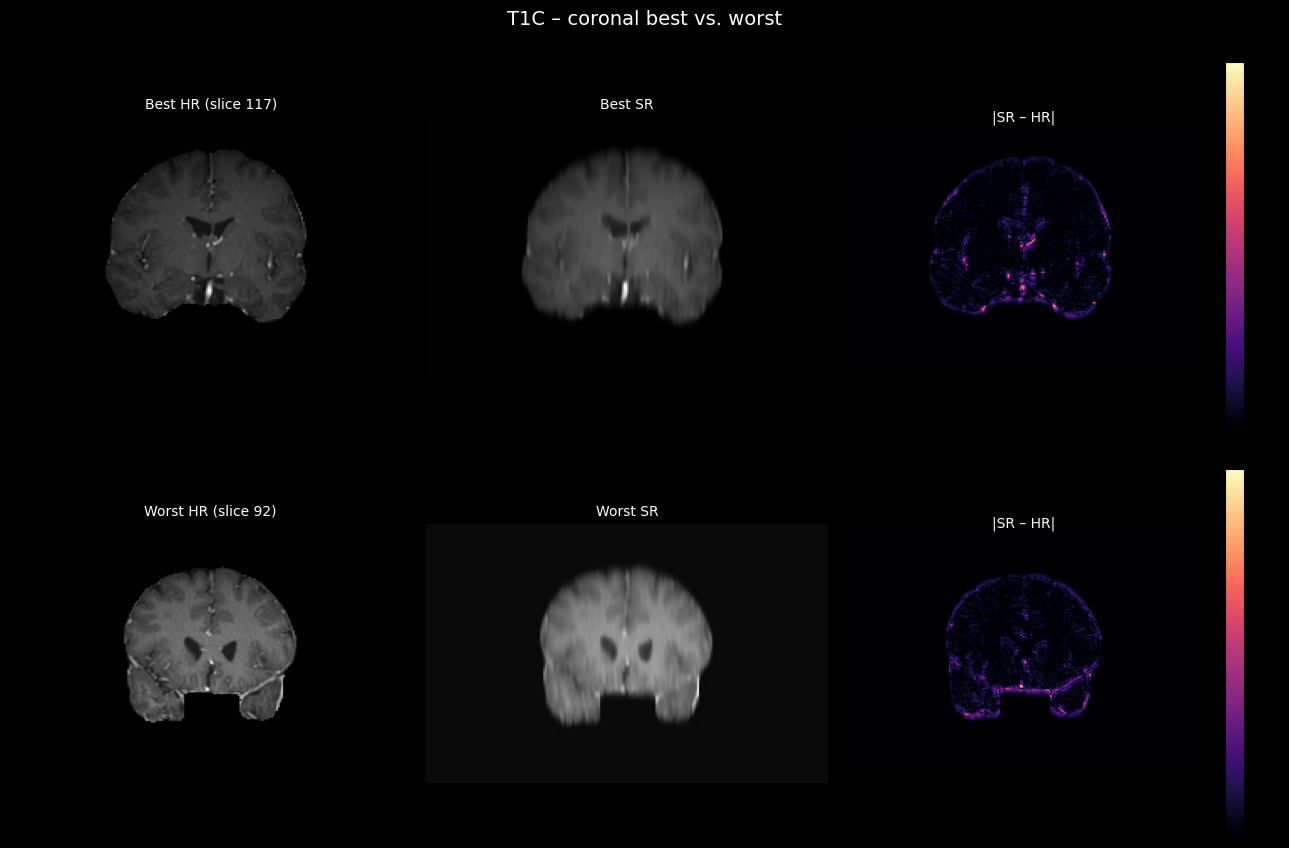

Processing T2W …


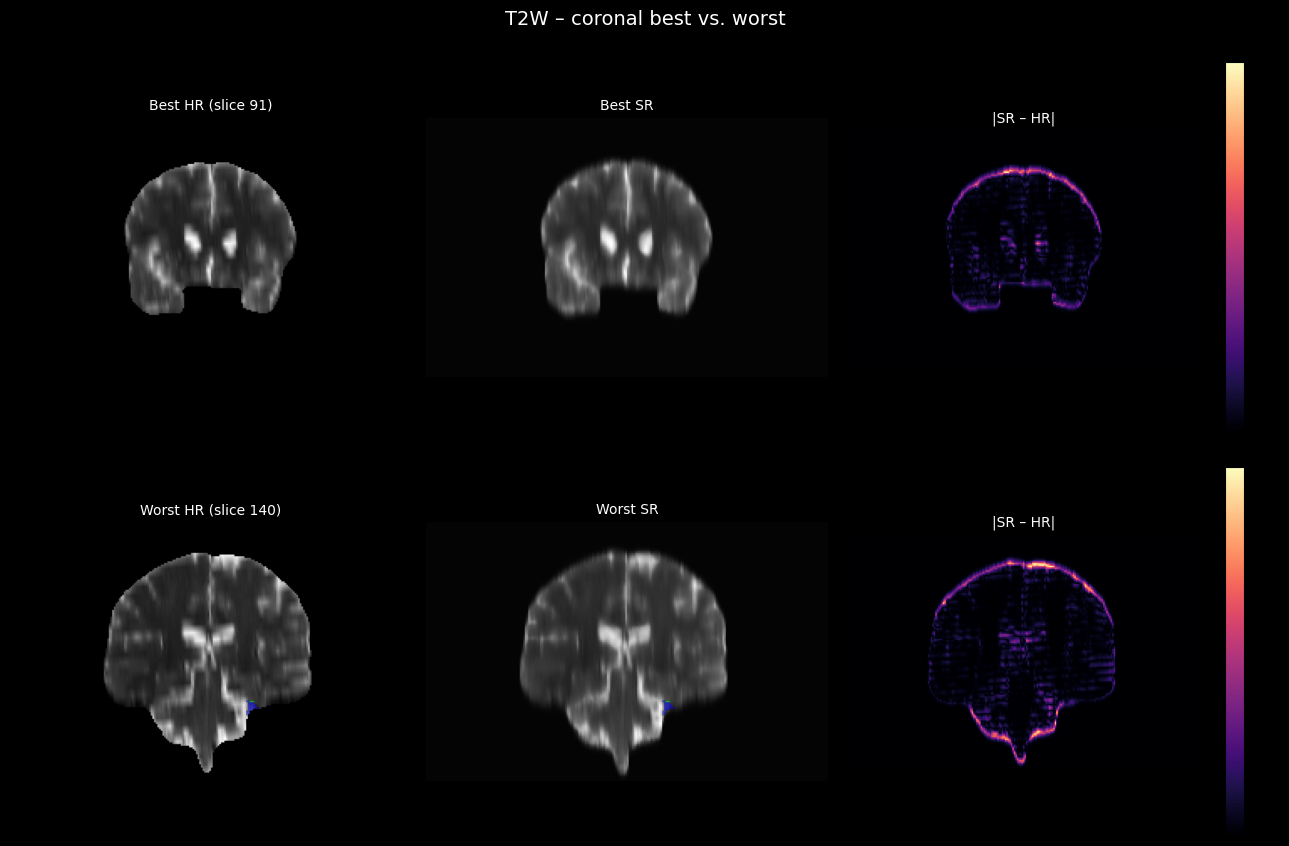

In [29]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple
from skimage.metrics import structural_similarity as ssim


# =============== CONFIGURATION ==========================================
HR     = Path("/home/mario/x2go_shared/sr/original_volumes/BraTS-MEN-00004-000")
SR     = Path("/home/mario/x2go_shared/sr/output_volumes")
PULSES = ["t1c", "t2w"]

ignore_slices: List[int] = np.arange(0, 80).tolist() + np.arange(160, 300).tolist()
# =======================================================================


# ---------- metric helpers (unchanged except MI stays robust) ----------
def compute_psnr_slice(hr, sr, max_val=None):
    diff = hr - sr
    mse = np.mean(diff**2, dtype=np.float64)
    if mse == 0:
        return np.inf
    peak = max_val if max_val is not None else float(np.max(hr))
    return 10 * np.log10(peak**2 / mse)


def compute_ssim_slice(hr, sr, win_size: int = 7):
    return ssim(hr, sr, win_size=win_size, data_range=hr.max() - hr.min())


def compute_mi_slice(hr, sr, bins: int = 64):
    joint, *_ = np.histogram2d(hr.ravel(), sr.ravel(), bins=bins)
    p_xy = joint / joint.sum()
    p_x = p_xy.sum(1, keepdims=True)
    p_y = p_xy.sum(0, keepdims=True)
    with np.errstate(divide='ignore'):
        log_term = np.where(p_xy > 0, np.log(p_xy / (p_x * p_y)), 0.)
    mi = np.nansum(p_xy * log_term)
    return mi / np.log(2)
# -----------------------------------------------------------------------


def best_worst_coronal_indices(hr_vol: np.ndarray,
                               sr_vol: np.ndarray,
                               axis: int,
                               ignore: List[int],
                               bins: int = 64) -> Tuple[int, int]:
    """Return indices of best / worst coronal slices, skipping *ignore*."""
    hr_s = np.moveaxis(hr_vol, axis, 0)
    sr_s = np.moveaxis(sr_vol, axis, 0)
    n_slices = hr_s.shape[0]

    psnr = np.array([np.nan] * n_slices)
    ssim_ = np.array([np.nan] * n_slices)
    mi = np.array([np.nan] * n_slices)

    for i in range(n_slices):
        if i in ignore:
            continue
        psnr[i] = compute_psnr_slice(hr_s[i], sr_s[i])
        ssim_[i] = compute_ssim_slice(hr_s[i], sr_s[i])
        mi[i] = compute_mi_slice(hr_s[i], sr_s[i], bins=bins)

    def norm(arr):
        good = ~np.isnan(arr)
        if not np.any(good):
            return np.full_like(arr, np.nan)
        mn, mx = np.nanmin(arr[good]), np.nanmax(arr[good])
        return (arr - mn) / (mx - mn) if mx != mn else np.zeros_like(arr)

    score = np.nanmean(np.stack([norm(psnr), norm(ssim_), norm(mi)], 1), 1)

    # Fallback in the unlikely event all remaining slices are NaN
    if np.all(np.isnan(score)):
        avail = [i for i in range(n_slices) if i not in ignore]
        return avail[0], avail[0]

    best = int(np.nanargmax(score))
    worst = int(np.nanargmin(score))
    return best, worst


# ------------------------ visual helpers -------------------------------
def rgba_overlay(seg_slice):
    """Return an RGBA array with fixed colours for labels 1/2/3."""
    h, w = seg_slice.shape
    ov = np.zeros((h, w, 4), dtype=np.float32)            # RGBA
    ov[seg_slice == 1] = (1, 0, 0, 0.5)   # red
    ov[seg_slice == 2] = (0, 1, 0, 0.5)   # green
    ov[seg_slice == 3] = (0, 0, 1, 0.5)   # blue
    return ov


def overlay_slice(ax, img, seg, title):
    ax.set_facecolor('black')
    img_r = np.rot90(img, k=1)            # fix orientation
    seg_r = np.rot90(seg, k=1)
    ax.imshow(img_r, cmap='gray')
    ax.imshow(rgba_overlay(seg_r))
    ax.set_title(title, fontsize=10, color='white')
    ax.axis('off')


def show_best_worst(hr, sr, seg, best_idx, worst_idx, pulse, axis: int = 1):
    hr_s = np.moveaxis(hr, axis, 0)
    sr_s = np.moveaxis(sr, axis, 0)
    sg_s = np.moveaxis(seg, axis, 0)

    def diff_map(h, s): return np.abs(s - h)

    fig, axes = plt.subplots(2, 3, figsize=(13, 9), facecolor='black')
    plt.suptitle(f"{pulse.upper()} – coronal best vs. worst",
                 y=0.97, color='white', fontsize=14)

    # ---- BEST ----
    overlay_slice(axes[0, 0], hr_s[best_idx], sg_s[best_idx],
                  f"Best HR (slice {best_idx})")
    overlay_slice(axes[0, 1], sr_s[best_idx], sg_s[best_idx],
                  "Best SR")
    dm = np.rot90(diff_map(hr_s[best_idx], sr_s[best_idx]), k=1)
    im = axes[0, 2].imshow(dm, cmap='magma')
    axes[0, 2].axis('off'); axes[0, 2].set_title("|SR – HR|", color='white', fontsize=10)
    plt.colorbar(im, ax=axes[0, 2], fraction=0.046)

    # ---- WORST ----
    overlay_slice(axes[1, 0], hr_s[worst_idx], sg_s[worst_idx],
                  f"Worst HR (slice {worst_idx})")
    overlay_slice(axes[1, 1], sr_s[worst_idx], sg_s[worst_idx],
                  "Worst SR")
    dm2 = np.rot90(diff_map(hr_s[worst_idx], sr_s[worst_idx]), k=1)
    im2 = axes[1, 2].imshow(dm2, cmap='magma')
    axes[1, 2].axis('off'); axes[1, 2].set_title("|SR – HR|", color='white', fontsize=10)
    plt.colorbar(im2, ax=axes[1, 2], fraction=0.046)

    for ax in axes.ravel():
        ax.set_facecolor('black')

    plt.tight_layout()
    plt.show()
# ------------------------------------------------------------------------


# ====================== MAIN LOOP =======================================
for pulse in PULSES:
    print(f"Processing {pulse.upper()} …")

    hr_path  = HR / f"{HR.name}-{pulse}.nii.gz"
    sr_path  = SR / f"{HR.name}-{pulse}.nii.gz"
    seg_path = HR / f"{HR.name}-seg.nii.gz"

    hr = nib.load(hr_path).get_fdata(dtype=np.float32)
    sr = nib.load(sr_path).get_fdata(dtype=np.float32)
    seg = nib.load(seg_path).get_fdata()

    if hr.shape != sr.shape or hr.shape != seg.shape:
        raise ValueError("Volume shapes mismatch.")

    best, worst = best_worst_coronal_indices(hr, sr,
                                             axis=1,
                                             ignore=ignore_slices,
                                             bins=64)
    show_best_worst(hr, sr, seg, best, worst, pulse, axis=1)
